<h1>Evaluations of NNet_Agent</h1> 

In [1]:
import os
import sys
import numpy as np
import glob
import csv

import sys

sys.path.append('..')

from matplotlib.colors import ListedColormap
from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent, NN_Agent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility
from pommerman import my_utility
from pommerman import constants
from pommerman.NN.pommerman_neural_net import PommermanNNet

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from io import BytesIO

from skimage.transform import rescale

nn_args = {
    'input_channels': 8,
    'board_x': constants.BOARD_SIZE_ONE_VS_ONE,
    'board_y': constants.BOARD_SIZE_ONE_VS_ONE,
}

def visual_matrix(mat, ax, image=None, alpha=0.3):
    x_step = 1
    y_step = 1
    x_offset = 0
    y_offset = 0
    if image is None:
        ax.matshow(mat, cmap=ListedColormap(['w']))
    else:
        ax.imshow(image, alpha=alpha)
        x_step = len(image)/mat.shape[1]
        y_step = len(image)/mat.shape[0]
        x_offset = x_step/2
        y_offset = y_step/2
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            y = x_offset + i * y_step
            x = y_offset + j * x_step
            c = mat[j, i]
            ax.text(y, x, str(c), va='center', ha='center', fontsize=12)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

<h2>NNet_Agent</h2>

<h3>Overview:</h3>

<h4>NNet_Agent</h4>

* performs a MCTS at each action.
* selection (if all children available): using ucb $Qsa[(s, a)] + C * Ps[s][a] * math.sqrt(Ns[s]) / (1 + Nsa[(s, a)])$
* expansion (if not all children available): expand random unseen child. One expansion step expands 'my' and 'opponent' action.
* rollout: - <b>IF</b> node is terminal: get reward and backprobagate. <b>ELSE</b>: evaluate expanded node by nnet. Backprobagate Value from NNet.
* backprobagation: backprobagate rewards for 'me' and 'opponent' not the same. 'my' rewards update only 'my' Qsa, 'opponent' rewards update only 'opponent' Qsa.
* get action probability: return normalized distribution over $Nsa[(s, a)]$ (greedy: return maximum of $Nsa[(s, a)]$)

<h4>Learning process</h4>

* Self play
* Collect for each agent and each action: action-probs, canonical board state, reward (+rotated and mirrored)
* add to train examples
* start training the network
* evaluate network by playing old vs new network
* update if new nnet is better

<h4>Canonical board presentation:</h4>

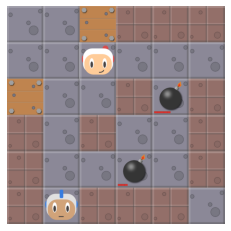

In [2]:
# Passage = 0, Rigid = 1, Wood = 2, Bomb = 3, Flames = 4
# ExtraBomb = 6, IncrRange = 7, Kick = 8, Agent0 = 10, Agent1 = 11
game_type = constants.GameType(4)

board = [[ 0,  0,  2,  1,  1,  1],
         [ 0,  0, 10,  0,  0,  0],
         [ 2,  0,  0,  1,  3,  1],
         [ 1,  0,  1,  0,  0,  1],
         [ 1,  0,  0,  3,  0,  1],
         [ 1, 11,  1,  1,  1,  0]]
bomb_info = [(0, 5, 2, None), (1, 3, 2, None)]

game_state = my_utility.get_gamestate(board, bomb_info)
game_data = my_utility.get_gamedata(game_state, game_type)

data = BytesIO()
my_utility.get_texture(data, game_data, None)
image = mpimg.imread(data)

#downscale
image = rescale(image, 0.25, anti_aliasing=False, multichannel=True)

plt.axis('off')
imgplot = plt.imshow(image)

Numpy-Array bit coded:
* Bit 1: Rigid
* Bit 2: Wood
* Bit 3: Item
* Bit 4: Me
* Bit 5: Opponent
* Bit 6-9: Bomb life
* Bit 10-12: Bomb strength
* Bit 13-14: Flame life

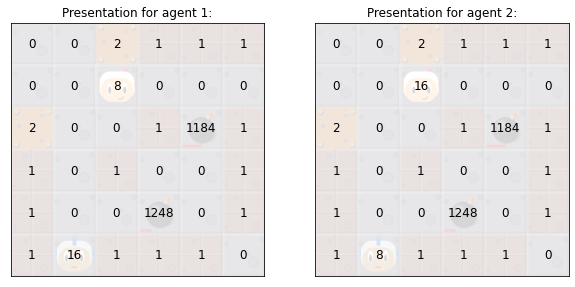

In [3]:
c_board_str_1, c_board_1 = NN_Agent.get_canonical_board_str_from_data(game_data, 0)
c_board_str_2, c_board_2 = NN_Agent.get_canonical_board_str_from_data(game_data, 1)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
titles = ['Presentation for agent 1:', 'Presentation for agent 2:']
axes = [axs[0], axs[1]]
mat = [c_board_1, c_board_2]
for i in range(len(mat)):
    axes[i].set_title(titles[i])
    visual_matrix(mat[i], axes[i], image, alpha=0.2)

<h4>NNet-Input</h4>

Split canonical board into 8 channels:
* Rigid - layer
* Wood - layer
* Item - layer
* Me - layer
* Opponent - layer
* Bomb life - layer
* Bomb strength - layer
* Flame life - layer

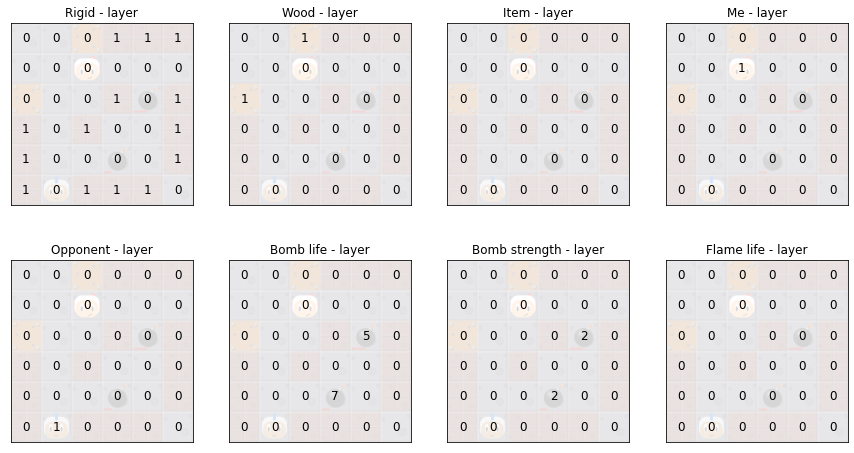

In [4]:
_, c_board = NN_Agent.get_canonical_board_str_from_data(game_data, 0)

nnet = PommermanNNet(**nn_args)
nn_input = nnet.get_nn_input(c_board)

fig, axs = plt.subplots(2, 4, figsize=(15,8))
titles = ['Rigid - layer', 'Wood - layer', 'Item - layer', 'Me - layer', 'Opponent - layer', 'Bomb life - layer', 'Bomb strength - layer', 'Flame life - layer']
axes = [axs[0,0], axs[0,1], axs[0,2], axs[0,3], axs[1,0], axs[1,1], axs[1,2], axs[1,3]]
for i in range(nn_input.shape[0]):
    axes[i].set_title(titles[i])
    visual_matrix(nn_input[i], axes[i], image, 0.2)

<h4>NNet-Architecture</h4>

* Conv2d (channels=512, kernel=3, stride=1, padding=1)
* BatchNorm2d (channels=512)
* Relu
* Conv2d (channels=512, kernel=3, stride=1, padding=1)
* BatchNorm2d (channels=512)
* Relu
* Conv2d (channels=512, kernel=3, stride=1)
* BatchNorm2d (channels=512)
* Relu
* Conv2d (channels=512, kernel=3, stride=1)
* BatchNorm2d (channels=512)
* Relu


* View to 1d


* Linear (size=1024)
* BatchNorm1d
* Relu
* Dropout (p=0.3)
* Linear (size=512)
* BatchNorm1d
* Relu
* Dropout (p=0.3)


* Conv2d (channels=512, kernel=3, stride=1, padding=1)
* BatchNorm2d (channels=512)


* pi: Linear(size=action_size)
* v: Linear(size=1)

<h4>Training</h4>

Loss function:

$L = \sum_t (v_{\theta}(s_t) - z_t)^2 - \pi_t log(p_{\theta}(s_t))$

<h4>Results</h4>

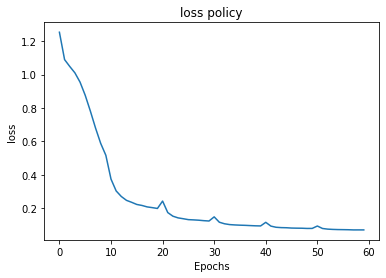

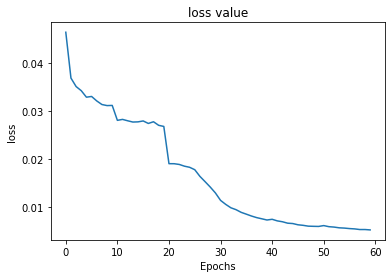

In [5]:
model_path = 'C:\\tmp\\Model\\analyse_1'

def read_loss_file(path):
    loss_pi = []
    loss_vi = []
    
    nnet_id = 1
    loss_file = os.path.join(path, f'nnet_{nnet_id}_loss.csv')
    while (os.path.exists(loss_file)):
        with open(loss_file, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=';', quotechar='|')
            for row in spamreader:
                if len(row) == 3:
                    loss_pi.append(float(row[1]))
                    loss_vi.append(float(row[2]))
        nnet_id += 1
        loss_file = os.path.join(path, f'nnet_{nnet_id}_loss.csv')
    return np.array(loss_pi), np.array(loss_vi)

loss_pi, loss_vi = read_loss_file(model_path)

plt.plot(loss_pi)
plt.title('loss policy')
plt.xlabel('Epochs')
plt.ylabel('loss') 
plt.show()

plt.plot(loss_vi)
plt.title('loss value')
plt.xlabel('Epochs')
plt.ylabel('loss') 
plt.show()

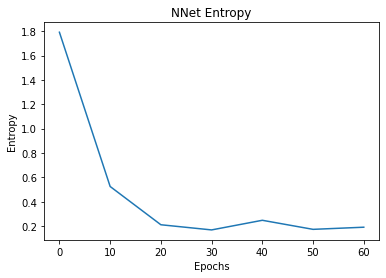

In [10]:
def get_nnet_checkpoints(path):
    nnets = []
    nnet_id = 1
    nnet_path = os.path.join(path, f'nnet_{nnet_id}.pth.tar')
    while (os.path.exists(nnet_path)):
        nnets.append(nnet_path)
        nnet_id += 1
        nnet_path = os.path.join(path, f'nnet_{nnet_id}.pth.tar')
    return nnets

def get_board_predictions(game_data, nnet, agent_id):
    _, c_board = NN_Agent.get_canonical_board_str_from_data(game_data, agent_id)
    a_pos = game_data.agents[agent_id].position
    
    pos = []
    ps = []
    vs = []
    c_board[a_pos] = 0
    
    for row in range(c_board.shape[0]):
        for col in range(c_board.shape[1]):
            if c_board[row, col] == 0:
                c_board[row, col] = 8 * (1 + agent_id)
                nn_input = nnet.get_nn_input(c_board)
                p, v = nnet.predict(nn_input)
                pos.append((row, col))
                ps.append(p)
                vs.append(v)
                c_board[row, col] = 0

    return pos, np.vstack(ps), np.vstack(vs)

def calc_mean_entropy(_probs):
    if len(_probs.shape) == 1:
        return - np.sum(_probs * np.log(_probs))
    else:
        return - np.sum(_probs * np.log(_probs)) / len(_probs)
    
def get_epoch_predictions(game, nnet_cps, es):
    _board_values = []
    _board_probs = []
    _eval_pos = None
    for _nnet_cp in nnet_cps:
        _nnet = PommermanNNet(**nn_args)

        if _nnet_cp:
            _head, _tail = os.path.split(_nnet_cp)
            _nnet.load_checkpoint(_head, _tail)

        _pos, _ps, _vs = get_board_predictions(game, _nnet, 0)
        _board_values.append(_vs)
        _board_probs.append(_ps)
        _eval_pos = _pos
    return _eval_pos, _board_values, _board_probs

epoch_step = 10
nnet_checkpoints = [None]
nnet_checkpoints.extend(get_nnet_checkpoints(model_path))

eval_pos, board_values, board_probs = get_epoch_predictions(game_data, nnet_checkpoints, epoch_step)
                          
mean_entropy = []
for mp in board_probs:
    mean_entropy.append(calc_mean_entropy(mp))

x_axis = np.array(list(range(len(mean_entropy)))) * epoch_step
plt.title('NNet Entropy')
plt.xlabel('Epochs')
plt.ylabel('Entropy') 
plt.plot(x_axis, mean_entropy)
plt.show()

<h5>Board values</h5>

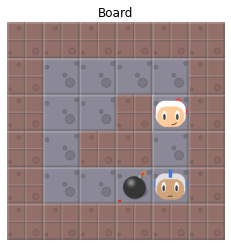

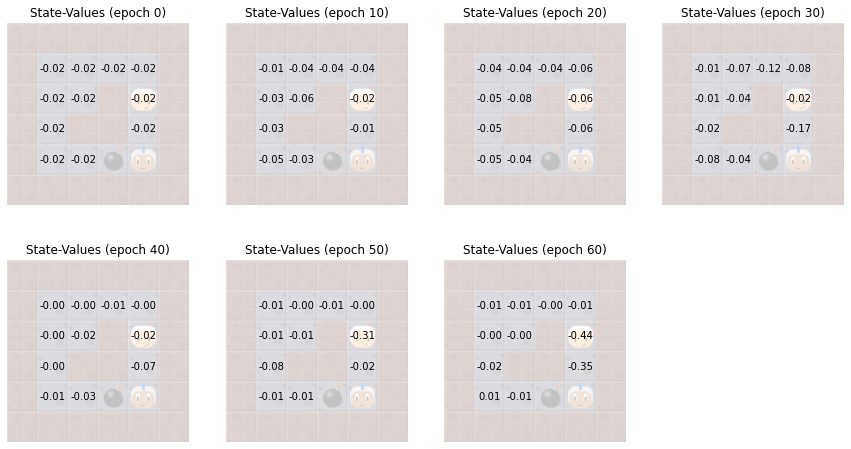

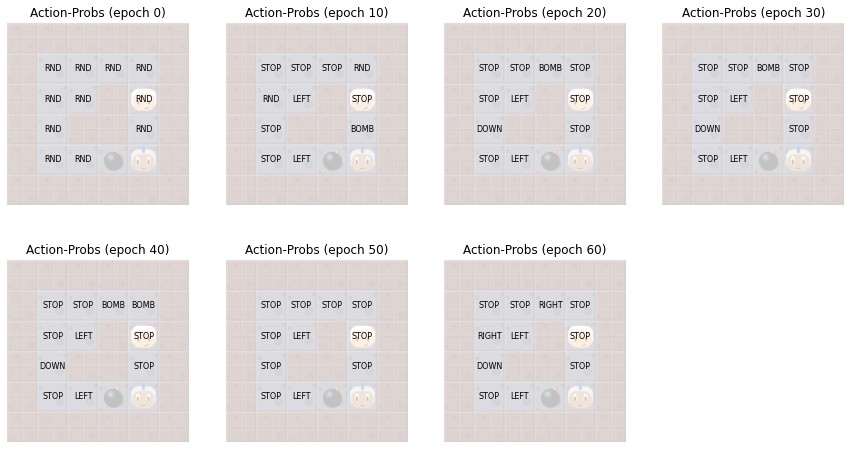

In [23]:
def plot_nnet_pred_values(game_data, agent_id, nnet_cps, epoch_step=10):
    _png = BytesIO()
    my_utility.get_texture(_png, game_data, None)
    _img = mpimg.imread(_png)

    #downscale
    _board_img = rescale(_img, 0.25, anti_aliasing=False, multichannel=True)

    plt.axis('off')
    imgplot = plt.imshow(_board_img)
    plt.title('Board')
    plt.show()
    
    # print value predictions
    _e = 0
    _pic_len = len(_board_img) / game_data.board.shape[0]
    
    _eval_pos, _values, _probs = get_epoch_predictions(game_data, nnet_cps, epoch_step)

    plt.figure(figsize=(15, 8))
    grid = 240
    for i, b_v in enumerate(_values):
        plt.subplot(240 + i + 1)
        plt.axis('off')
        imgplot = plt.imshow(_board_img, alpha=0.3)

        plt.title(f'State-Values (epoch {_e})')
        for j, pos in enumerate(_eval_pos):
            plt.text(pos[1] * _pic_len + _pic_len/2, pos[0] * _pic_len + _pic_len/2,
                     "{:.2f}".format(b_v[j][0]), va='center', ha='center')
        _e += epoch_step
        plt.axis('off')
    plt.show()
    
    # print probs predictions
    _e = 0
    plt.figure(figsize=(15, 8))
    grid = 240
    for i, b_p in enumerate(_probs):
        plt.subplot(240 + i + 1)
        plt.axis('off')
        imgplot = plt.imshow(_board_img, alpha=0.3)

        actions = ['STOP', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'BOMB']
        plt.title(f'Action-Probs (epoch {_e})')
        for j, pos in enumerate(_eval_pos):
            text = 'RND' if np.max(b_p[j]) < 0.5 else actions[(np.argmax(b_p[j]))]
            plt.text(pos[1] * _pic_len + _pic_len/2, pos[0] * _pic_len + _pic_len/2,
                     text, va='center', ha='center', fontsize='8')
        _e += epoch_step
        plt.axis('off')
    plt.show()
    
    
board = [[ 1,  1,  1,  1,  1,  1],
         [ 1,  0,  0,  0,  0,  1],
         [ 1,  0,  0,  1, 10,  1],
         [ 1,  0,  1,  1,  0,  1],
         [ 1,  0,  0,  3,  11, 1],
         [ 1,  1,  1,  1,  1,  1]]
bomb_info = [(0, 1, 2, None)] #, (1, 1, 2, None)]

game_state = my_utility.get_gamestate(board, bomb_info)
game_data = my_utility.get_gamedata(game_state, game_type)

epoch_step = 10
nnet_checkpoints = [None]
nnet_checkpoints.extend(get_nnet_checkpoints(model_path))

plot_nnet_pred_values(game_data, 0, nnet_checkpoints, epoch_step)